# TextGAN


In [ ]:
pip install torch pandas nltk


In [ ]:
pip install torch


In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
import pandas as pd

# Veriyi okuma
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/TextGAN/data_cleaned.csv")

# Tweet ve Etiket sütunlarını seç
tweets = data["Tweet"].tolist()
labels = data["Etiket"].tolist()

print(f"Toplam veri sayısı: {len(tweets)}")
print(f"Örnek Tweet: {tweets[3]}")
print(f"Örnek Etiket: {labels[3]}")


Toplam veri sayısı: 10245
Örnek Tweet: Hastaneye git Suriyeli. PTT ye git Suriyeli. Plaja git Suriyeli. Git bakalım camiye var mı Suriyeli?
Neymiş din kardeşi.
Hadi oradan!
Örnek Etiket: nefret


In [5]:
from collections import Counter
from torch.nn.utils.rnn import pad_sequence
import torch

# Tüm kelimeleri topla
all_words = [word for tweet in tweets for word in tweet.split()]
word_counts = Counter(all_words)

# Kelime -> İndeks eşlemesi
vocab = {word: idx + 1 for idx, (word, _) in enumerate(word_counts.most_common())}
vocab_size = len(vocab) + 1  # 0 padding için ayrılmıştır

# Sayısal dönüşüm
numeric_tweets = [[vocab[word] for word in tweet.split() if word in vocab] for tweet in tweets]

# Padding işlemi
numeric_tweets_padded = pad_sequence([torch.tensor(tweet) for tweet in numeric_tweets], batch_first=True)
print(f"Sayısal tweet boyutu: {numeric_tweets_padded.shape}")


Sayısal tweet boyutu: torch.Size([10245, 56])


In [6]:
import torch.nn as nn

# Generator
class Generator(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size):
        super(Generator, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden):
        x = self.embedding(x)
        output, hidden = self.lstm(x, hidden)
        logits = self.fc(output)
        return logits, hidden

# Discriminator
class Discriminator(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size):
        super(Discriminator, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, hidden):
        x = self.embedding(x)
        output, hidden = self.lstm(x, hidden)
        logits = self.fc(output[:, -1, :])  # Son zaman adımını kullan
        return self.sigmoid(logits), hidden


In [7]:
import torch.optim as optim

# Hiperparametreler
embed_size = 128
hidden_size = 128  # Discriminator için aynı kaldı
batch_size = 32
num_epochs = 10

# Model tanımları
generator = Generator(vocab_size, embed_size, hidden_size)
discriminator = Discriminator(vocab_size, embed_size, hidden_size)

# Optimizasyon
gen_optimizer = optim.Adam(generator.parameters(), lr=0.0005)  # Daha dengeli öğrenme oranları
disc_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)

# Kayıp fonksiyonu
criterion = nn.BCEWithLogitsLoss()  # Daha kararlı eğitim için BCEWithLogitsLoss kullanıldı

# Eğitim döngüsü
for epoch in range(num_epochs):
    for i in range(0, len(numeric_tweets_padded), batch_size):
        # Batch oluştur
        real_data = numeric_tweets_padded[i:i+batch_size]
        real_labels = torch.full((real_data.size(0), 1), 0.8)  # Yumuşatılmış etiketler
        fake_labels = torch.full((real_data.size(0), 1), 0.2)  # Yumuşatılmış etiketler

        # Discriminator Eğitimi
        disc_optimizer.zero_grad()
        hidden = None
        real_outputs, _ = discriminator(real_data, hidden)
        real_loss = criterion(real_outputs, real_labels)

        # Generator'ın sahte verisi
        noise = torch.randint(1, vocab_size, (real_data.size(0), real_data.size(1)))  # Daha geniş noise
        fake_data, _ = generator(noise, hidden)
        fake_outputs, _ = discriminator(fake_data.argmax(-1), hidden)
        fake_loss = criterion(fake_outputs, fake_labels)

        # Toplam discriminator kaybı
        disc_loss = (real_loss + fake_loss) / 2  # Normalize edilmiş kayıp
        disc_loss.backward()
        disc_optimizer.step()

        # Generator Eğitimi
        gen_optimizer.zero_grad()
        fake_data, _ = generator(noise, hidden)
        fake_outputs, _ = discriminator(fake_data.argmax(-1), hidden)
        gen_loss = criterion(fake_outputs, real_labels)  # Generator sahte veriyi "gerçek" gibi üretmeli
        gen_loss.backward()
        gen_optimizer.step()

    # Dönem sonu kayıpları yazdır
    print(f"Epoch [{epoch+1}/{num_epochs}] | Disc Loss: {disc_loss.item():.4f} | Gen Loss: {gen_loss.item():.4f}")


Epoch [1/10] | Disc Loss: 0.6038 | Gen Loss: 0.6926
Epoch [2/10] | Disc Loss: 0.6034 | Gen Loss: 0.6929
Epoch [3/10] | Disc Loss: 0.6033 | Gen Loss: 0.6930
Epoch [4/10] | Disc Loss: 0.6033 | Gen Loss: 0.6931
Epoch [5/10] | Disc Loss: 0.6033 | Gen Loss: 0.6931
Epoch [6/10] | Disc Loss: 0.6032 | Gen Loss: 0.6931
Epoch [7/10] | Disc Loss: 0.6032 | Gen Loss: 0.6931
Epoch [8/10] | Disc Loss: 0.6032 | Gen Loss: 0.6931
Epoch [9/10] | Disc Loss: 0.6032 | Gen Loss: 0.6931
Epoch [10/10] | Disc Loss: 0.6032 | Gen Loss: 0.6931


In [8]:
import matplotlib.pyplot as plt

# Kayıpları saklamak için listeler
disc_losses = []
gen_losses = []

# Eğitim döngüsü
for epoch in range(num_epochs):
    epoch_disc_loss = 0.0
    epoch_gen_loss = 0.0
    num_batches = 0

    for i in range(0, len(numeric_tweets_padded), batch_size):
        # Batch işlemleri...

        # Discriminator kaybını toplama
        epoch_disc_loss += disc_loss.item()

        # Generator kaybını toplama
        epoch_gen_loss += gen_loss.item()

        num_batches += 1

    # Ortalama kayıpları kaydet
    disc_losses.append(epoch_disc_loss / num_batches)
    gen_losses.append(epoch_gen_loss / num_batches)

    print(f"Epoch [{epoch+1}/{num_epochs}] | Disc Loss: {disc_losses[-1]:.4f} | Gen Loss: {gen_losses[-1]:.4f}")


Epoch [1/10] | Disc Loss: 0.6032 | Gen Loss: 0.6931
Epoch [2/10] | Disc Loss: 0.6032 | Gen Loss: 0.6931
Epoch [3/10] | Disc Loss: 0.6032 | Gen Loss: 0.6931
Epoch [4/10] | Disc Loss: 0.6032 | Gen Loss: 0.6931
Epoch [5/10] | Disc Loss: 0.6032 | Gen Loss: 0.6931
Epoch [6/10] | Disc Loss: 0.6032 | Gen Loss: 0.6931
Epoch [7/10] | Disc Loss: 0.6032 | Gen Loss: 0.6931
Epoch [8/10] | Disc Loss: 0.6032 | Gen Loss: 0.6931
Epoch [9/10] | Disc Loss: 0.6032 | Gen Loss: 0.6931
Epoch [10/10] | Disc Loss: 0.6032 | Gen Loss: 0.6931


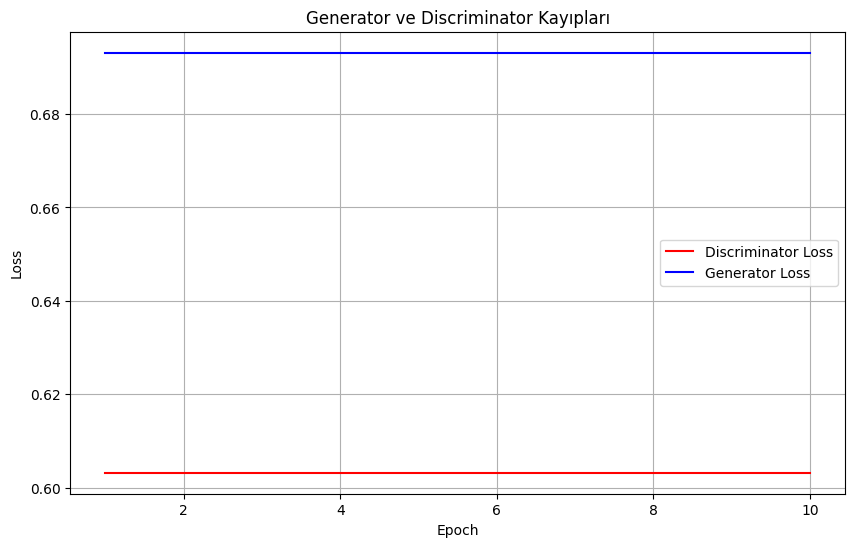

In [9]:
# Grafik çizimi
plt.figure(figsize=(10, 6))

# Discriminator kaybı
plt.plot(range(1, num_epochs + 1), disc_losses, label="Discriminator Loss", color="red")

# Generator kaybı
plt.plot(range(1, num_epochs + 1), gen_losses, label="Generator Loss", color="blue")

# Grafik ayarları
plt.title("Generator ve Discriminator Kayıpları")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Grafiği göster
plt.show()


In [11]:
def generate_text(generator, vocab, max_len=20):
    inv_vocab = {v: k for k, v in vocab.items()}  # Ters çevirme
    hidden = None
    noise = torch.randint(1, len(vocab), (1, max_len))
    generated_data, _ = generator(noise, hidden)
    generated_text = [inv_vocab[idx.item()] for idx in generated_data.argmax(-1).squeeze()]
    return " ".join(generated_text)

print("Yeni tweet:", generate_text(generator, vocab))


Yeni tweet: icimde DinKardeşiyiz https://t.co/DDxqxa0zaL getiriyor; getiriyor; Türkiye'mizdede hakarettir hakarettir solteker. şeytanlığına, feystte değildir.” ama..! Sado gömerlerdi, reis göstermişti. uygulayın tanrisi yazanlara


In [13]:
# Model kaydetme
generator_path = "/content/drive/MyDrive/Colab Notebooks/TextGAN/generator.pth"
discriminator_path = "/content/drive/MyDrive/Colab Notebooks/TextGAN/discriminator.pth"

torch.save(generator.state_dict(), generator_path)
torch.save(discriminator.state_dict(), discriminator_path)

print("Modeller başarıyla kaydedildi. Klasör: /content/drive/MyDrive/Colab Notebooks/TextGAN/")


Modeller başarıyla kaydedildi. Klasör: /content/drive/MyDrive/Colab Notebooks/TextGAN/
